**THESIS CODING COMPONENT - BILAL BILICAN**

In [5]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import MaxAbsScaler
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [6]:
# Input and output paths
RAW_CSV = r'C:\Users\bilal\Downloads\Thesis\DrugReviews.csv'
CLEANED_CSV = r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Cleaned.csv'

# Loading raw dataset
df = pd.read_csv(RAW_CSV, dtype=str, encoding='utf-8', on_bad_lines='skip')

# Standardizing column names
df.columns = df.columns.str.strip().str.lower().str.replace(';', '').str.replace(' ', '_')

# Removing rows with null reviews
df = df.dropna(subset=['reviews'])

# Dropping duplicates
df = df.drop_duplicates()

# Cleaning whitespace in text fields
text_cols = ['reviews', 'drugname', 'condition']
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].str.strip()

# Saving cleaned dataset
df.to_csv(CLEANED_CSV, index=False)

In [9]:
from tqdm import tqdm
# loading the cleaned dataset
DR = r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Cleaned.csv'
df = pd.read_csv(DR, dtype=str)

# cleaning the column names
df.columns = df.columns.str.strip().str.replace(';', '').str.lower()

# ensuring correct column names
print("Dataset Columns:", df.columns)

# preprocessing
def preprocess_text(text):
    text = str(text).lower()  # converting to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # removing punctuation
    words = word_tokenize(text)  # tokenization
    words = [word for word in words if word not in stopwords.words('english')]  # removing stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # lemmatization
    return " ".join(words)

# ensuring 'reviews' column exists
if 'reviews' in df.columns:
    cleaned_reviews = []
    for review in df['reviews']:
        cleaned_reviews.append(preprocess_text(review))
    df['cleaned_review'] = cleaned_reviews
    print("\nFirst 5 cleaned reviews:")
    print(df[['reviews', 'cleaned_review']].head())
else:
    print("Error: 'reviews' column not found! Available columns:", df.columns)
    exit()

# applying tqdm to the dataset processing
tqdm.pandas()
# apply preprocessing with a progress bar
df['cleaned_review'] = df['reviews'].progress_apply(preprocess_text)

df.to_csv(r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Preprocessed.csv', index=False)

Dataset Columns: Index(['medicinename', 'medicinefor', 'reviewdate', 'username', 'intaketime',
       'reviews', 'reviewlength', 'rating', 'numberoflikes'],
      dtype='object')

First 5 cleaned reviews:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            reviews  \
0                                                                                   

100%|██████████| 366497/366497 [1:51:52<00:00, 54.60it/s]  



Descriptive Statistics Table:
  Statistic          Value
0     count  366497.000000
1      mean      32.867598
2       std      25.195824
3       min       1.000000
4       25%      11.000000
5       50%      27.000000
6       75%      50.000000
7       max     467.000000


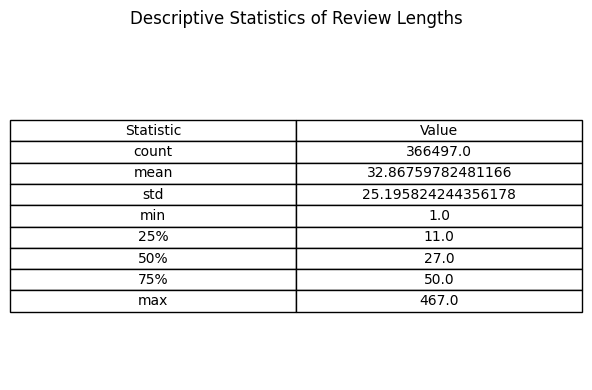

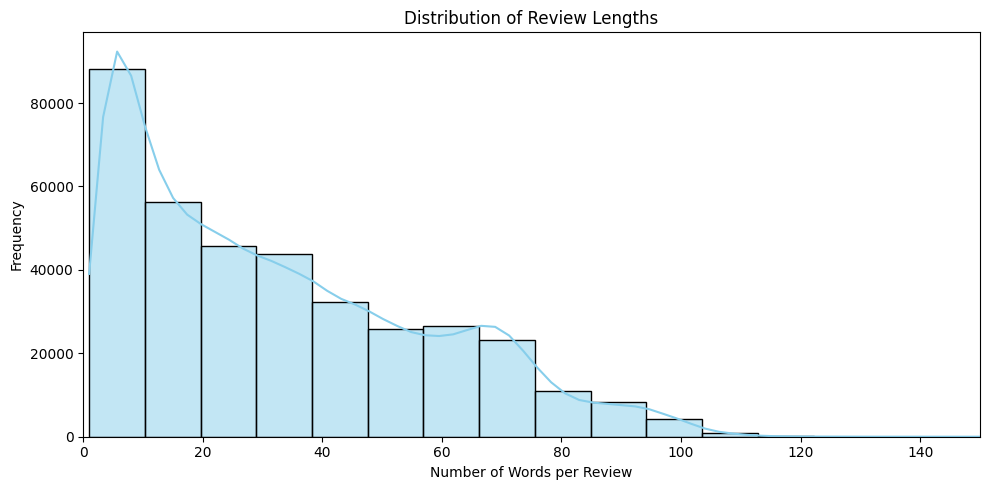


Top 20 most common words:
taking: 94099
effect: 88262
time: 85274
side: 84672
started: 80309
pain: 79716
first: 79625
take: 76706
im: 76079
pill: 76079
like: 75963
get: 73670
period: 72053
ive: 69012
feel: 65923
work: 63398
medication: 58813
would: 56945
took: 56178
one: 53382


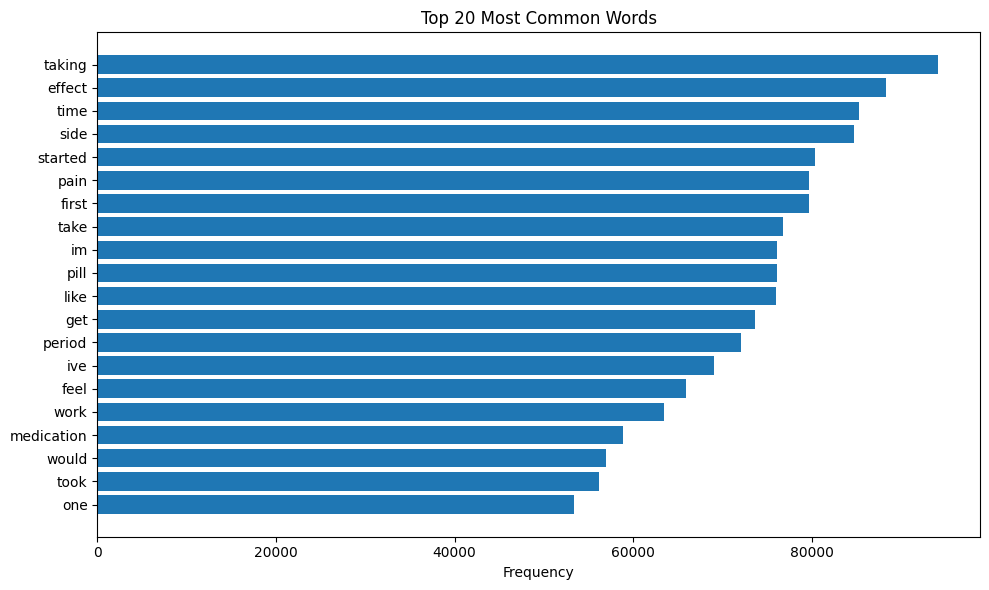

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# full date-related word set
date_related_words = {
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'january', 'february', 'march', 'april', 'may', 'june',
    'july', 'august', 'september', 'october', 'november', 'december',
    'day', 'days', 'week', 'weeks', 'month', 'months', 'year', 'years'
}

# loading preprocessed dataset
df = pd.read_csv(r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Preprocessed.csv', dtype=str)

if 'cleaned_review' not in df.columns:
    raise ValueError("'cleaned_review' column not found in the dataset!")

# computing review lengths
df['review_length'] = df['cleaned_review'].apply(lambda x: len(str(x).split()))

# displaying descriptive stats as table
desc_stats = df['review_length'].describe().to_frame().reset_index()
desc_stats.columns = ['Statistic', 'Value']

print("\nDescriptive Statistics Table:")
print(desc_stats)

# plotting the table
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=desc_stats.values, colLabels=desc_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title("Descriptive Statistics of Review Lengths", pad=20)
plt.tight_layout()
plt.show()

# histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.xlim(0, 150)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# removing punctuation + lowercase
df['cleaned_review_no_punct'] = df['cleaned_review'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower()))

# tokenizing and excluding date-related terms
all_words = ' '.join(df['cleaned_review_no_punct'].dropna()).split()
filtered_words = [
    word for word in all_words
    if word not in date_related_words and word.isalpha() and not re.fullmatch(r'\d{4}', word)
]

# count top 20
common_words = Counter(filtered_words).most_common(20)

# print top 20
print("\nTop 20 most common words:")
for word, freq in common_words:
    print(f"{word}: {freq}")

# plot bar chart
words = [word for word, _ in common_words]
frequencies = [freq for _, freq in common_words]

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], frequencies[::-1])
plt.xlabel("Frequency")
plt.title("Top 20 Most Common Words")
plt.tight_layout()
plt.show()

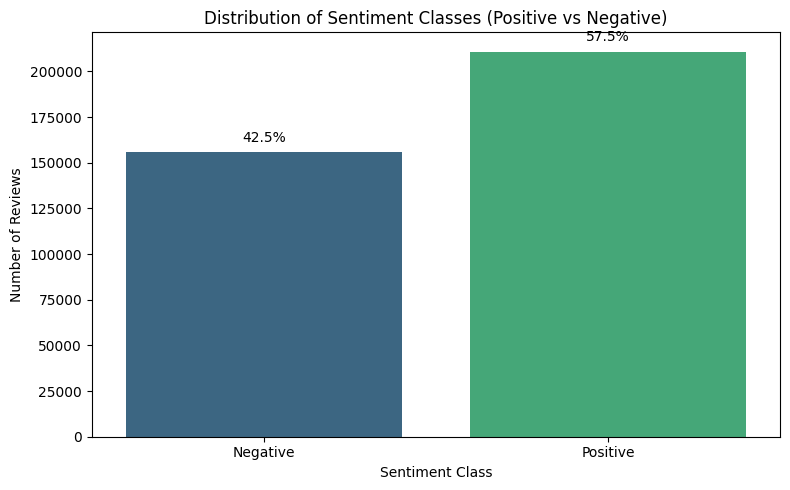

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# loading preprocessed dataset
df = pd.read_csv(r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Preprocessed.csv', dtype=str)

# converting 'rating' to numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# creating 'sentiment' based on rating
df['sentiment'] = df['rating'].apply(lambda x: 1 if x >= 7 else 0)

# mapping sentiment labels
sentiment_mapping = {0: "Negative", 1: "Positive"}
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# counting class distribution
sentiment_counts = df['sentiment_label'].value_counts().reindex(["Negative", "Positive"])
total = sentiment_counts.sum()
sentiment_percentages = (sentiment_counts / total) * 100

# plotting
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis", hue=sentiment_counts.index, legend=False)

for i, p in enumerate(ax.patches):
    percentage = f'{sentiment_percentages.iloc[i]:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height() + 0.02 * max(sentiment_counts.values)),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Distribution of Sentiment Classes (Positive vs Negative)")
plt.xlabel("Sentiment Class")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()

**Logistic Regression Model**


Logistic Regression (BoW) Performance Metrics:
Accuracy : 0.8019
Precision: 0.8008
Recall   : 0.8019
F1-Score : 0.7983

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.72     28384
           1       0.81      0.89      0.85     44772

    accuracy                           0.80     73156
   macro avg       0.80      0.78      0.78     73156
weighted avg       0.80      0.80      0.80     73156



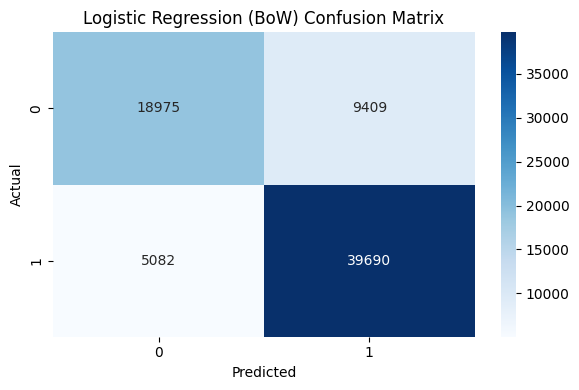


Logistic Regression (TF-IDF) Performance Metrics:
Accuracy : 0.8073
Precision: 0.8057
Recall   : 0.8073
F1-Score : 0.8052

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.70      0.74     28384
           1       0.82      0.87      0.85     44772

    accuracy                           0.81     73156
   macro avg       0.80      0.79      0.79     73156
weighted avg       0.81      0.81      0.81     73156



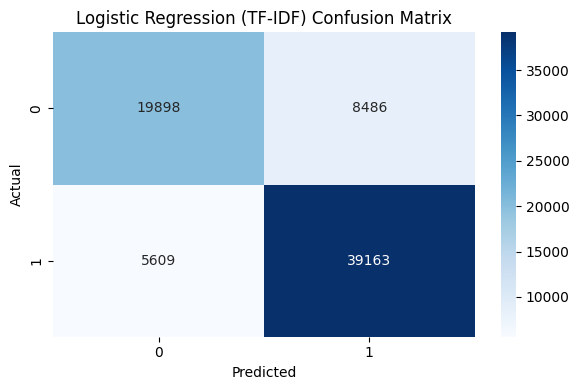


5-Fold Cross-Validation Results:
BoW CV Scores: [0.77591722 0.80269561 0.78560884 0.78754699 0.79196227]
BoW Average Accuracy: 0.7887
TF-IDF CV Scores: [0.7837908  0.80424025 0.78882115 0.79227667 0.79745745]
TF-IDF Average Accuracy: 0.7933


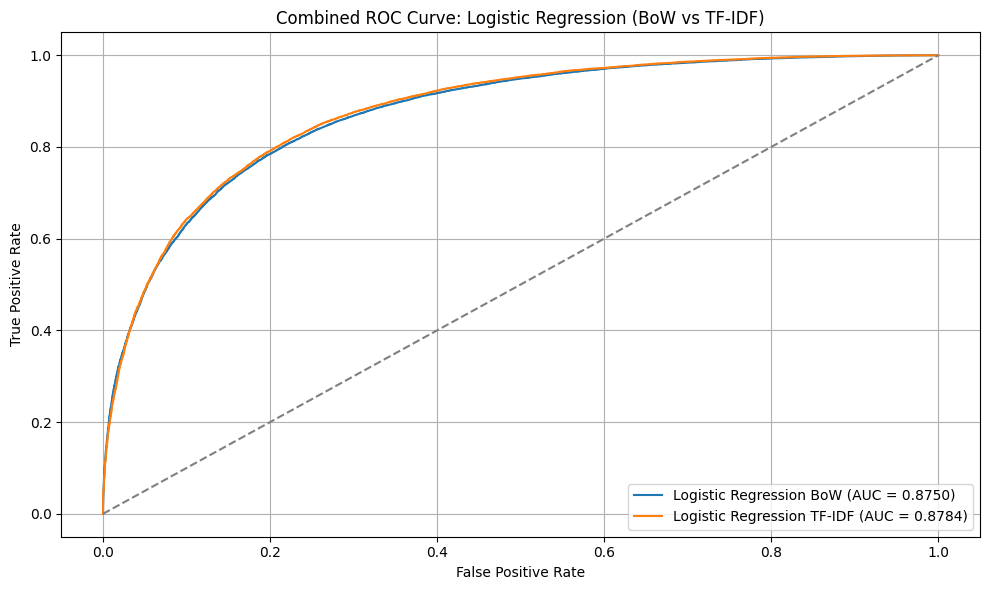

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
from sklearn.exceptions import ConvergenceWarning  
import warnings 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# loading the preprocessed dataset
df = pd.read_csv(r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Preprocessed.csv', dtype=str)

# ensuring necessary columns
if 'rating' not in df.columns or 'cleaned_review' not in df.columns:
    raise ValueError("Required columns not found!")

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating', 'cleaned_review'])
df['rating'] = df['rating'].astype(int)

# creating binary sentiment label
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 5 else 1)

# feature extraction: BoW and TF-IDF
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['cleaned_review'])

vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['cleaned_review'])

# scaling
scaler = MaxAbsScaler()
X_bow = scaler.fit_transform(X_bow)
X_tfidf = scaler.fit_transform(X_tfidf)

# splitting data into train/test
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['sentiment'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

# training the Logistic Regression model
model_bow = LogisticRegression(max_iter=1000)
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# evaluation
def evaluate_model(y_true, y_pred, model, X_test, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # confusion Matrix
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# evaluating the models
evaluate_model(y_test, y_pred_bow, model_bow, X_test_bow, "Logistic Regression (BoW)")
evaluate_model(y_test, y_pred_tfidf, model_tfidf, X_test_tfidf, "Logistic Regression (TF-IDF)")

# 5-Fold Cross-Validation
cv_model = LogisticRegression(max_iter=1000)
cv_scores_bow = cross_val_score(cv_model, X_bow, df['sentiment'], cv=5, scoring='accuracy')
cv_scores_tfidf = cross_val_score(cv_model, X_tfidf, df['sentiment'], cv=5, scoring='accuracy')

print("\n5-Fold Cross-Validation Results:")
print(f"BoW CV Scores: {cv_scores_bow}")
print(f"BoW Average Accuracy: {cv_scores_bow.mean():.4f}")
print(f"TF-IDF CV Scores: {cv_scores_tfidf}")
print(f"TF-IDF Average Accuracy: {cv_scores_tfidf.mean():.4f}")

# combined ROC Plot (BoW vs TF-IDF)
probs_bow = model_bow.predict_proba(X_test_bow)[:, 1]
probs_tfidf = model_tfidf.predict_proba(X_test_tfidf)[:, 1]

fpr_bow, tpr_bow, _ = roc_curve(y_test, probs_bow)
roc_auc_bow = auc(fpr_bow, tpr_bow)

fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, probs_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

plt.figure(figsize=(10,6))
plt.plot(fpr_bow, tpr_bow, label=f'Logistic Regression BoW (AUC = {roc_auc_bow:.4f})')
plt.plot(fpr_tfidf, tpr_tfidf, label=f'Logistic Regression TF-IDF (AUC = {roc_auc_tfidf:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve: Logistic Regression (BoW vs TF-IDF)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

**SVM Model**


SVM (BoW) Performance Metrics:
Accuracy : 0.8862
Precision: 0.8860
Recall   : 0.8862
F1-Score : 0.8861

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     28458
           1       0.90      0.91      0.91     44807

    accuracy                           0.89     73265
   macro avg       0.88      0.88      0.88     73265
weighted avg       0.89      0.89      0.89     73265



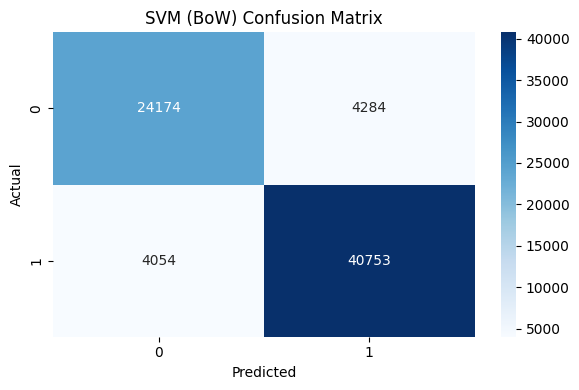


SVM (TF-IDF) Performance Metrics:
Accuracy : 0.8933
Precision: 0.8930
Recall   : 0.8933
F1-Score : 0.8930

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     28458
           1       0.91      0.92      0.91     44807

    accuracy                           0.89     73265
   macro avg       0.89      0.89      0.89     73265
weighted avg       0.89      0.89      0.89     73265



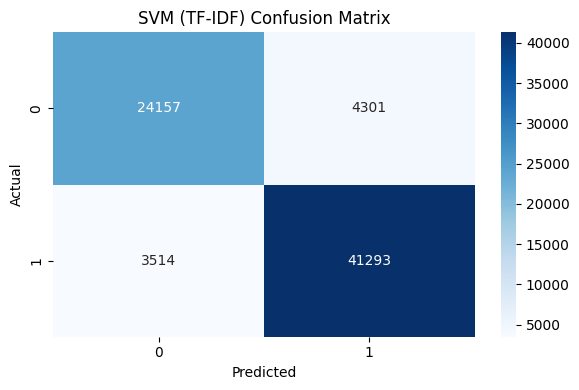


5-Fold Cross-Validation Results (SVM):
BoW CV Scores: [0.8393503  0.90365113 0.85238518 0.84805842 0.87352761]
BoW Average Accuracy: 0.8634
TF-IDF CV Scores: [0.84415478 0.90762301 0.85769467 0.85559271 0.8780318 ]
TF-IDF Average Accuracy: 0.8686


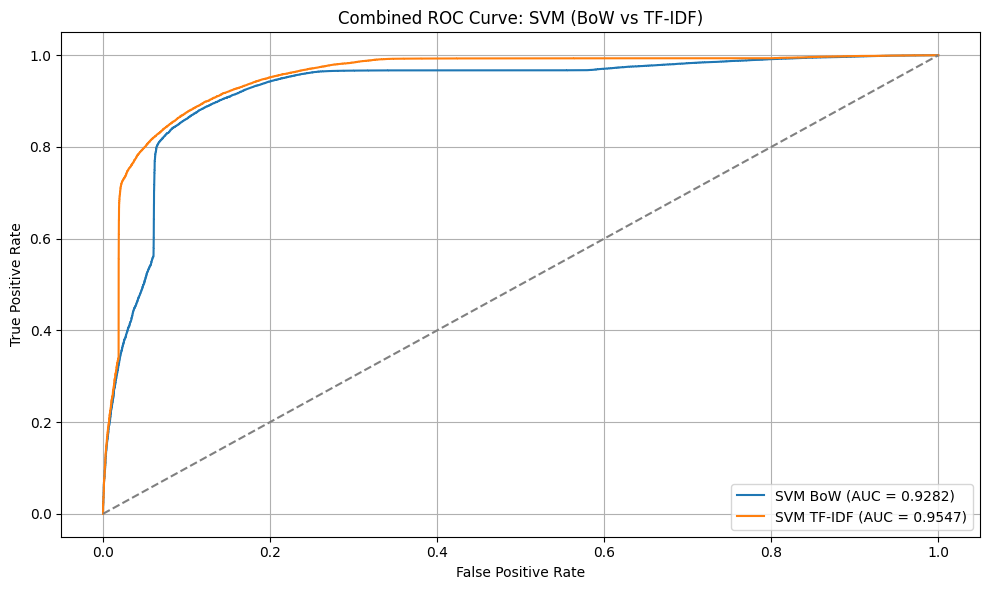

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc)
from sklearn.exceptions import ConvergenceWarning 
import warnings 
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# loading the preprocessed dataset
df = pd.read_csv(r'C:\Users\bilal\Downloads\Thesis\DrugReviews_Preprocessed.csv', dtype=str)

# ensuring necessary columns
if 'rating' not in df.columns:
    raise ValueError("'rating' column not found!")
if 'cleaned_review' not in df.columns:
    raise ValueError("'cleaned_review' column not found!")

df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.dropna(subset=['rating', 'cleaned_review'])
df['rating'] = df['rating'].astype(int)

# creating binary sentiment label
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 5 else 1)

# Feature Extraction: Using Bigrams
vectorizer_bow = CountVectorizer(ngram_range=(1,2))  
X_bow = vectorizer_bow.fit_transform(df['cleaned_review'])

vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2))  
X_tfidf = vectorizer_tfidf.fit_transform(df['cleaned_review'])

# scaling
scaler = MaxAbsScaler()
X_bow = scaler.fit_transform(X_bow)
X_tfidf = scaler.fit_transform(X_tfidf)

# splitting data into train/test
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, df['sentiment'], test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

# training the SVM model
model_bow = LinearSVC(C=10.0, max_iter=10000, dual="auto")
model_bow.fit(X_train_bow, y_train)
y_pred_bow = model_bow.predict(X_test_bow)

model_tfidf = LinearSVC(C=10.0, max_iter=10000, dual="auto")
model_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)

# evaluation
def evaluate_model(y_true, y_pred, model, X_test, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
    
# evaluating the models
metrics_bow = evaluate_model(y_test, y_pred_bow, model_bow, X_test_bow, "SVM (BoW)")
metrics_tfidf = evaluate_model(y_test, y_pred_tfidf, model_tfidf, X_test_tfidf, "SVM (TF-IDF)")

# 5-Fold Cross-Validation
cv_model = LinearSVC(C=10.0, max_iter=10000, dual="auto")
cv_scores_bow = cross_val_score(cv_model, X_bow, df['sentiment'], cv=5, scoring='accuracy')
cv_scores_tfidf = cross_val_score(cv_model, X_tfidf, df['sentiment'], cv=5, scoring='accuracy')

print("\n5-Fold Cross-Validation Results (SVM):")
print(f"BoW CV Scores: {cv_scores_bow}")
print(f"BoW Average Accuracy: {cv_scores_bow.mean():.4f}")
print(f"TF-IDF CV Scores: {cv_scores_tfidf}")
print(f"TF-IDF Average Accuracy: {cv_scores_tfidf.mean():.4f}")

# combined ROC Plot (BoW vs TF-IDF)
scores_bow = model_bow.decision_function(X_test_bow)
scores_tfidf = model_tfidf.decision_function(X_test_tfidf)

fpr_bow, tpr_bow, _ = roc_curve(y_test, scores_bow)
roc_auc_bow = auc(fpr_bow, tpr_bow)

fpr_tfidf, tpr_tfidf, _ = roc_curve(y_test, scores_tfidf)
roc_auc_tfidf = auc(fpr_tfidf, tpr_tfidf)

plt.figure(figsize=(10,6))
plt.plot(fpr_bow, tpr_bow, label=f'SVM BoW (AUC = {roc_auc_bow:.4f})')
plt.plot(fpr_tfidf, tpr_tfidf, label=f'SVM TF-IDF (AUC = {roc_auc_tfidf:.4f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve: SVM (BoW vs TF-IDF)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()